# Text encoding
## Encoding text word-by-word based on frequency

* [Tokenizer](https://keras.io/preprocessing/text/#tokenizer) by word frequency with some minimal lexical pre-processing **texts_to_sequences()**
* [pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) up to expected NN input size.


In [1]:
# Tokenizer example
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer

sentences = [
    'I love you!',
    'do i owe you?'
    'i need a break',
    'your\'s jokes are the BEST.' ,
    'you are so butefull to me'
]

tknzr = Tokenizer(num_words=100) # top 100
tknzr.fit_on_texts(sentences)
idx = tknzr.word_index
print(idx)
# note no punctuations or upper case

{'i': 1, 'you': 2, 'are': 3, 'love': 4, 'do': 5, 'owe': 6, 'need': 7, 'a': 8, 'break': 9, "your's": 10, 'jokes': 11, 'the': 12, 'best': 13, 'so': 14, 'butefull': 15, 'to': 16, 'me': 17}


In [2]:
sequences = tknzr.texts_to_sequences(sentences)
print(sequences)

[[1, 4, 2], [5, 1, 6, 2, 1, 7, 8, 9], [10, 11, 3, 12, 13], [2, 3, 14, 15, 16, 17]]


In [3]:
# ignoring unknown words by default, safe for inference with trained NN
test_data = ['i love you!' , 'i REALLY love you!']
print(test_data)
print(tknzr.texts_to_sequences(test_data))

['i love you!', 'i REALLY love you!']
[[1, 4, 2], [1, 4, 2]]


In [4]:
# to capture difference in meaning with unknown words, use special token to encode unknown word
tknzr2 = Tokenizer(num_words=100, oov_token='<OOV>') # Out Of Vacubulary data
tknzr2.fit_on_texts(sentences)
print(test_data)
print(tknzr2.texts_to_sequences(test_data))
print(tknzr2.word_index)

['i love you!', 'i REALLY love you!']
[[2, 5, 3], [2, 1, 5, 3]]
{'<OOV>': 1, 'i': 2, 'you': 3, 'are': 4, 'love': 5, 'do': 6, 'owe': 7, 'need': 8, 'a': 9, 'break': 10, "your's": 11, 'jokes': 12, 'the': 13, 'best': 14, 'so': 15, 'butefull': 16, 'to': 17, 'me': 18}


Evry sentence after encoding should be uniform (same length) by padding up to expected NN input size.
* [pad_sequences](https://keras.io/preprocessing/sequence/#pad_sequences) is available in keras.preprocessing.sequence.

In [5]:
# padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

unpadded = tknzr2.texts_to_sequences(test_data)
padded  = pad_sequences(unpadded) # default = pre 
print(unpadded, type(unpadded), '\n----\n', padded, type(padded))


[[2, 5, 3], [2, 1, 5, 3]] <class 'list'> 
----
 [[0 2 5 3]
 [2 1 5 3]] <class 'numpy.ndarray'>


In [6]:
# padding up to expected NN input size
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=5)
print( sequences, '\n---\n', padded) # pre or post

[[1, 4, 2], [5, 1, 6, 2, 1, 7, 8, 9], [10, 11, 3, 12, 13], [2, 3, 14, 15, 16, 17]] 
---
 [[ 1  4  2  0  0]
 [ 5  1  6  2  1]
 [10 11  3 12 13]
 [ 2  3 14 15 16]]


## Embedding
Embedding takes encoded words and establish sentiment from them, so that you can begin to classify and then later predict texts. Like a first layer that does encoding in pre-trined NN.

There's a library called [TensorFlow Data Services](https://www.tensorflow.org/datasets/catalog/overview) (**TFDS**), that contains many data sets and lots of different categories. TFDS is useful in pre-trining embending function (NN). Exaple is given with [IMDB dataset](https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification).

In [13]:
# installed as 'tensorflow_datasets' python package
import tensorflow_datasets as tfds

# See all registered datasets
tfds.list_builders()[:10]

['abstract_reasoning',
 'aflw2k3d',
 'amazon_us_reviews',
 'bair_robot_pushing_small',
 'bigearthnet',
 'binarized_mnist',
 'binary_alpha_digits',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011']

In [8]:
# Large Movie Review Dataset   https://ai.stanford.edu/~amaas/data/sentiment/
from tensorflow.keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    path="imdb.npz", num_words=None, skip_top=0, maxlen=None, seed=113, 
    start_char=1, oov_char=2, index_from=3
)

17465344/17464789 [==============================] - 2s 0us/step


**Embedding** is a specialized compression method [tf.keras.layers.Embedding](https://keras.io/layers/embeddings/#embedding) 1D fixed very long ints -> n-D fixed size floats.
Embeding learns compress function as correlation extractor from labels (PCA type) during back propagation cycle.
See:
- [Word embeddings TF post](https://www.tensorflow.org/tutorials/text/word_embeddings)
- [G crash course on Embeddings](https://developers.google.com/machine-learning/crash-course/embeddings/obtaining-embeddings)

OOV number is actualy indicator of absence of information (null). Embending will perform better if informed on such nulls. Use **masking** to indicate some inputs shoul be ignored `layers.Embedding(input_dim=5000, output_dim=16, mask_zero=True)`

input_array[:2] 
 [[102 435 860 270 106  71 700  20 614 121]
 [466 214 330 458  87 372  99 871 663 130]]
Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 10, 3)             3000      
_________________________________________________________________
global_average_pooling1d_14  (None, 3)                 0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 4         
Total params: 3,004
Trainable params: 3,004
Non-trainable params: 0
_________________________________________________________________


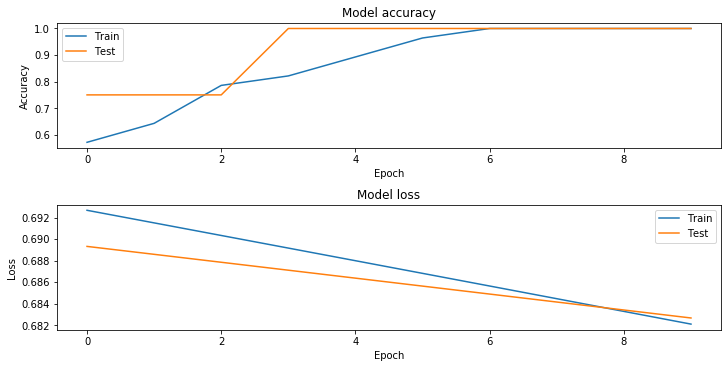

In [33]:
import numpy as np
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import keras_util as u

vocab_size = 1000
embedding_dim = 3
max_length = 10
samples = 32 # rows - sentences

np.random.seed(42)
# after linear encoding and padding
input = np.random.randint(vocab_size, size=(samples, max_length))
labels = np.random.randint(1, size=(samples, 1)) # binary
print('input_array[:2] \n', input_array[:2])

embending = layers.Embedding(vocab_size, embedding_dim, input_length=max_length)
model = models.Sequential([
    embending,
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(input, labels, validation_split=0.1
                   , epochs=10, verbose=0)
u.plot_history(history)

In [37]:
# look at embending of first rows
rows_n = 2
embending_input = input_array[:rows_n]
embending_output = embending(embending_input)
assert embending_output.shape == (rows_n, max_length, embedding_dim)
print(embending_input)
print(embending_output)

[[102 435 860 270 106  71 700  20 614 121]
 [466 214 330 458  87 372  99 871 663 130]]
tf.Tensor(
[[[ 0.00818308 -0.00413965 -0.05619576]
  [-0.01588088  0.03778666  0.02479491]
  [-0.02659393  0.03635139 -0.03850446]
  [ 0.0307826   0.0293899  -0.00930943]
  [ 0.01420298  0.01660119  0.03567019]
  [ 0.02897268 -0.011735   -0.03600772]
  [ 0.02294286  0.0018158  -0.03317294]
  [ 0.0227377   0.02730775 -0.05367161]
  [ 0.02122924 -0.03668297 -0.0597632 ]
  [ 0.00257829 -0.02196066  0.03746425]]

 [[ 0.00734752 -0.03265685  0.02450337]
  [ 0.05810168 -0.03306248 -0.05680072]
  [ 0.05464444 -0.0220705   0.02349565]
  [ 0.03908596  0.04668885 -0.02637091]
  [ 0.0365642   0.04884149 -0.05514646]
  [ 0.05256447  0.01787435 -0.02748318]
  [ 0.02500096 -0.02295047 -0.04190208]
  [-0.00658025  0.03728316  0.01405924]
  [ 0.05977383  0.01712094  0.01901042]
  [ 0.01216917 -0.01609586 -0.02663914]]], shape=(2, 10, 3), dtype=float32)


In [41]:
predictions = model.predict(input_array[:rows_n])
print("lablels \n", labels[:rows_n])
print("predictions \n", predictions)

lablels 
 [[0]
 [0]]
predictions 
 [[0.49384236]
 [0.49149117]]


In practice *advanced encoding* is needed to capture additional relevant information (aka context, emoji, sarcasm). **Attention** - one of the methods to help selecting such indirect information. For an example of attention mechanism study *seq2seq* model in [TensorFlow Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt) and [2015 Attention-based Neural Machine Translation Luong's paper](https://arxiv.org/abs/1508.04025v5).

## N dimentional vector visualization
Similar as in CNN to see learned features is very benefitial for practical NN modeling. TF offers [embending projector](https://projector.tensorflow.org/). See [TF emendig doc](https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_learned_embeddings) on example of dumping learned weights in embending layer.

Class `tfds.features.text.SubwordTextEncoder` is invertible TextEncoder using word pieces with a byte-level fallback. See [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer). It goes deep in word structure to encode even more information. Case sensitive, accounts for punctuation and parts of the words (prefix, suffix?). Note, SubwordTextEncoder encodes by word parts. Sequencing position became critical for efficient learning, use it with RNN!